In [6]:
#!/usr/bin/env python3

## Before running the script change term_width to an integer in utils.py

import torch
import torch.backends.cudnn as cudnn
import argparse
import logging
import pdb
import joblib
from torch.optim import Adam, SGD
from dataprepaug import *
from utils import *
from models import *
import numpy as np
from functools import partial
#from models.unet_model import UNet
from models.UnetPlusPlus import NestedUNet

#from .pspnet import *
#from .deeplab import *
import torch.optim as optim
import optuna
from models.unet import *
import glob
import os
import numbers
import math
import PIL
import cv2
import h5py

import random
import collections
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from optuna import Trial
import optuna

import matplotlib.pyplot as plt

In [15]:




def train(traindataload,net,optimizer, grad_sc,epoch,device):
        
        loss = 0
        epoch_loss = 0
        size=0
        acc=0
        nbatch = len(traindataload)
        for idx, (inputs, targets) in enumerate(traindataload):
                torch.cuda.empty_cache()
                inputs, targets = inputs.to(device).to(memory_format=torch.contiguous_format), targets.to(device).to(memory_format=torch.contiguous_format)
                outputs = net(inputs)
                size += outputs.shape[0]*outputs.shape[2]*outputs.shape[3]
                batch_loss = dice_loss(outputs.softmax(1),targets, multiclass=True)
                optimizer.zero_grad()
                grad_sc.scale(batch_loss).backward()
                grad_sc.step(optimizer)
                grad_sc.update()
                loss = batch_loss.item()
                epoch_loss += loss
                acc += (outputs.argmax(1) == targets.argmax(1)).type(torch.float).sum().item()
                #progress_bar(idx, len(traindataload), 'Loss: %.5f, Dice-Coef: %.5f'
                #         %(loss, 1-loss))#(loss/(idx+1)), (1-(loss/(idx+1)))))
                #log_msg = '\n'.join(['Training (%d/%d): Epoch: %d, Loss: %.5f,  Dice-Coef:  %.5f' %(idx,nbatch, epoch,loss, 1-loss)])
                #logging.info(log_msg)
        epoch_loss /= nbatch
        acc /= size
        
        print(f"Training epoch error: \n Acc: {(100*acc):>0.1f}%, Avg loss: {epoch_loss:>8f}, Dice: {(1-epoch_loss):>8f} \n")
        
        
        
def validation(validationload,net,epoch,device):
        loss = 0
        acc = 0
        epoch_loss=0
        size=0
        nbatch = len(validationload)
        net.eval()
        with torch.no_grad():
                for idx, (inputs, targets) in enumerate(validationload):
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = net(inputs)
                        batch_loss = dice_loss(outputs.softmax(1),targets, multiclass=True).item()
                        loss = batch_loss
                        epoch_loss +=loss
                        acc += (outputs.argmax(1) == targets.argmax(1)).type(torch.float).sum().item()
                        size += outputs.shape[0]*outputs.shape[2]*outputs.shape[3]
            
                        
                        #progress_bar(idx, len(validationload), 'Loss: %.5f, Dice-Coef: %.5f' %(loss, 1-loss))
                        #log_msg = '\n'.join(['Validation (%d/%d): Epoch: %d  Loss: %.5f,  Dice-Coef:  %.5f'
                #%(idx, nbatch, epoch, loss, 1-loss)])
                 #       logging.info(log_msg)
        
        epoch_loss /= nbatch
        acc /= size
        net.train()                
        print(f"Validation error: \n Acc: {(100*acc):>0.1f}%, Avg loss: {loss:>8f}, Dice: {(1-loss):>8f} \n")
        return epoch_loss, acc
                              

In [16]:
  
        
        
    
def optumaParams(trial):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        config = {
        "layer_multipler": trial.suggest_int("layer_multipler", 16,42),
        "lr": trial.suggest_loguniform("lr", 1e-5, 1e-1),
        "drop_rate": trial.suggest_loguniform("drop_rate", 1e-2, 2.5e-1),
        "n_layers": trial.suggest_int("n_layers",3,4),
        "batch_size": trial.suggest_int("batch_size",4,15),
        "optimizer": trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
    }

        
        net = NestedUNet(num_classes= 4, input_channels=4,layer_multipler= config["layer_multipler"], n_layers=config["n_layers"],
                   drop_rate=config["drop_rate"])
        #print(f'Layer_Muti: {config["layer_multipler"]}')
        net = net.to(device)    
        optimizer = getattr(optim, config["optimizer"])(net.parameters(), lr=config["lr"])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  
        
        traindataload = data_load(file_path_train, batch_size = config["batch_size"],datatype='Train')
        validationload = data_load(file_path_validation,batch_size =  config["batch_size"],datatype = 'Validation')
        
        print(f'Layers: {config["n_layers"]}, Layer Multiplyer: {config["layer_multipler"]}, Batch size: {config["batch_size"]}, LR: {config["lr"]}, Optimizer: {config["optimizer"]}, dropout: {config["drop_rate"]}')
        #file_path_train = "/home/jay/Documents/courses/Aicourse/Brats/HYPER/train/"
    
    
        #file_path_validation = "/home/jay/Documents/courses/Aicourse/Brats/HYPER/validation/"
        #print('loading Data')
    #net=NestedUNet(4,4, layer_multipler= config["layer_multipler"])   #load_model(args, class_num=4, mode='train')
    #optimizer = SGD(net.parameters(), lr=config["lr"], momentum=0.9, weight_decay=1e-8)
        
    
        
        #traindataload = data_load(file_path_train, batch_size = config["batch_size"],datatype='Train')
        #validationload = data_load(file_path_validation,batch_size = config["batch_size"],datatype = 'Validation')
    
        grad_sc = torch.cuda.amp.GradScaler(enabled=True)
        
        
        
        dice =1
        nodice =0
        for epoch in range(epochs):
        # Train Model
                print(f'Epoch: {epoch}')
                train(traindataload,net,optimizer, grad_sc,epoch,device)
                print('\n\n<Validation>')
                [validloss, acc] = validation(validationload,net,epoch,device)
                trial.report(validloss,epoch)
                
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
                    
                if dice > validloss:
                    
                    dice = validloss
                    nodice=0
                    best_wei = net.state_dict()
                    
                elif dice < validloss:
                    nodice+=1
                    if nodice >3:
                        early_stop=True
                        torch.save(best_wei, 'nestedUnet'+ str(trial.number)+'_earlystop.pth')
                        return validloss
        
        model_save = 'model_save_trial' + str(trial.number) + '.pth'
        torch.save(net.state_dict(), model_save)
        torch.cuda.empty_cache()
        return validloss   
        

        

# In[5]:





# In[ ]:



#if __name__ == "__main__":
file_path_train = "/home/jay/Documents/courses/Aicourse/Brats/HYPER/train/"
    
    
file_path_validation = "/home/jay/Documents/courses/Aicourse/Brats/HYPER/validation/"
    
    
    
    
    
epochs = 15
studyOptuma = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),pruner=optuna.pruners.MedianPruner() )
studyOptuma.optimize(optumaParams, n_trials=40, gc_after_trial=True)
joblib.dump(studyOptuma, "studyUnetPlusPlusNew.pkl")
torch.cuda.empty_cache()

[I 2022-03-18 09:21:04,874] A new study created in memory with name: no-name-c4590ab7-1dc7-42d6-91ed-346b2519230a


Layers: 3, Layer Multiplyer: 30, Batch size: 15, LR: 0.04225851199624289, Optimizer: Adam, dropout: 0.17096197833223084
Epoch: 0


[W 2022-03-18 09:21:05,603] Trial 0 failed because of the following error: NameError("name 'term_width' is not defined")
Traceback (most recent call last):
  File "/home/jay/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-16-f9b6740f0fb3>", line 46, in optumaParams
    train(traindataload,net,optimizer, grad_sc,epoch,device)
  File "<ipython-input-15-fe54818745dd>", line 21, in train
    progress_bar(idx, len(traindataload), 'Loss: %.5f, Dice-Coef: %.5f'
  File "/home/jay/Documents/courses/Aicourse/code_hyperParameterTune/utils.py", line 289, in progress_bar
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
NameError: name 'term_width' is not defined


 [>.................................................]  Step: 1m12s | Tot: 0ms | Loss: 0.89857, Dice-Coef: 0.10143

NameError: name 'term_width' is not defined

In [4]:
# joblib.dump(studyOptuma, "studyUnetPlusPlusNew.pkl")
# torch.cuda.empty_cache()

In [2]:
study = joblib.load("./studyUnetPlusPlusNew.pkl")
studyunet = joblib.load("./studyUnet.pkl")
print("Best trial until now Net Plus Plus:", study.best_trial.number)

print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

print("Best trial until now:", studyunet.best_trial.number)

print(" Params: ")
for key, value in studyunet.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now Net Plus Plus: 3
 Params: 
    layer_multipler: 21
    lr: 0.038834498423322414
    drop_rate: 0.011261298993052407
    n_layers: 4
    batch_size: 12
    optimizer: SGD
Best trial until now: 7
 Params: 
    layer_multipler: 22
    lr: 0.00740133781545379
    drop_rate: 0.1285983693778562
    n_layers: 4
    batch_size: 13
    optimizer: Adam


<ipython-input-15-107fd60d9f65>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
<ipython-input-15-107fd60d9f65>:7: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(studyunet)


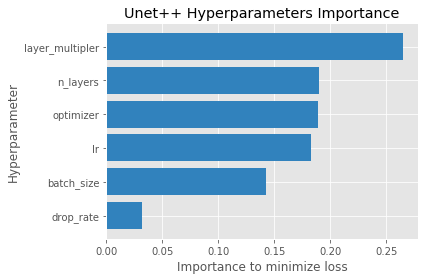

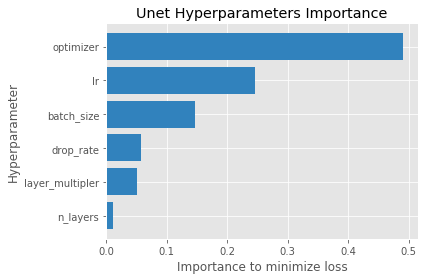

In [15]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Unet++ Hyperparameters Importance')
plt.xlabel('Importance to minimize loss')
plt.tight_layout()
plt.savefig('UnetPPhyper.png', bbox_inches='tight', dpi=600)

optuna.visualization.matplotlib.plot_param_importances(studyunet)
plt.title('Unet Hyperparameters Importance')
plt.xlabel('Importance to minimize loss')
plt.tight_layout()
plt.savefig('Unethyper.png', bbox_inches='tight', dpi=600)


<ipython-input-43-e0865fefee09>:1: ExperimentalWarning:

plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.



/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



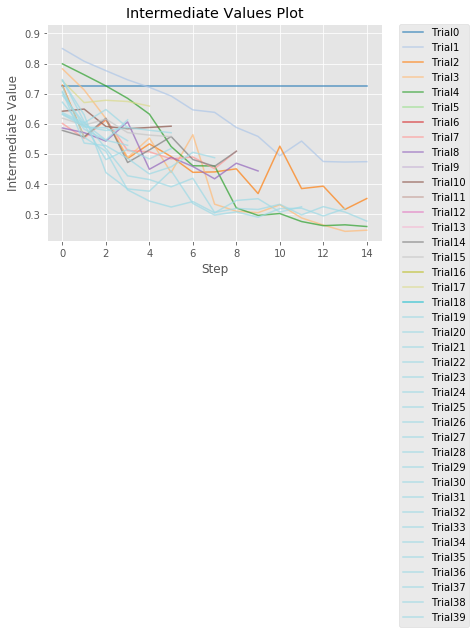

In [43]:
optuna.visualization.matplotlib.plot_intermediate_values(study)